In [156]:
library("dndscv")
library(dplyr)
library("biomaRt")
library(MASS) 
library(ggplot2)
library(lmtest)
library(stringr)
library(VennDiagram)


In [4]:
# data("dataset_simbreast", package="dndscv")
# dndsout = dndscv(mutations)

In [6]:
head(dndsout$sel_cv)

,gene_name,n_syn,n_mis,n_non,n_spl,n_ind,wmis_cv,wnon_cv,wspl_cv,wind_cv,pmis_cv,ptrunc_cv,pallsubs_cv,pind_cv,qmis_cv,qtrunc_cv,qallsubs_cv,qind_cv,pglobal_cv,qglobal_cv
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18057,TP53,1,43,5,4,5,113.660847,221.77049,221.77049,138.83304,0.000000e+00,1.110223e-16,0.000000e+00,1.730880e-09,0.000000e+00,2.230549e-12,0.000000e+00,0.0000347751,0.000000e+00,0.000000e+00
12977,PIK3CA,3,34,0,0,3,29.753120,0.00000,0.00000,30.70171,0.000000e+00,5.675133e-01,0.000000e+00,2.120005e-04,0.000000e+00,9.470189e-01,0.000000e+00,0.3549418299,0.000000e+00,0.000000e+00
9225,KRAS,1,21,0,0,0,125.980948,0.00000,0.00000,0.00000,0.000000e+00,8.435071e-01,0.000000e+00,1.000000e+00,0.000000e+00,9.470189e-01,0.000000e+00,1.0000000000,0.000000e+00,0.000000e+00
18924,VHL,3,9,1,0,4,24.752010,38.25134,38.25134,204.48680,7.457582e-09,2.230207e-02,7.974558e-09,1.324216e-08,2.996606e-05,9.470189e-01,2.002711e-05,0.0001330242,3.996803e-15,2.007494e-11
1296,APC,2,8,10,0,6,2.818805,31.17322,31.17322,23.08026,4.963347e-02,2.811491e-10,2.116310e-09,1.809029e-06,7.706433e-01,1.412142e-06,6.074112e-06,0.0090863005,1.308953e-13,5.259635e-10
1465,ARID1A,1,7,10,0,3,3.295779,53.46864,53.46864,14.35701,3.636417e-02,2.956191e-12,2.384704e-11,1.840854e-03,7.706433e-01,2.969642e-08,1.197777e-07,1.0000000000,1.394107e-12,4.668167e-09


In [8]:
dndsout$globaldnds

,name,mle,cilow,cihigh
,<chr>,<dbl>,<dbl>,<dbl>
wmis,wmis,1.0224047,0.9856968,1.060480
wnon,wnon,1.0645505,0.9840495,1.151637
wspl,wspl,0.9711421,0.8659233,1.089146
wtru,wtru,1.0347080,0.9671087,1.107032
wall,wall,1.0245512,0.9883161,1.062115


In [9]:
head(dndsout$annotmuts)

,sampleID,chr,pos,ref,mut,gene,strand,ref_cod,mut_cod,ref3_cod,mut3_cod,aachange,ntchange,codonsub,impact,pid
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Sample_1,1,871244,G,C,SAMD11,1,G,C,AGA,ACA,R133T,G398C,AGA>ACA,Missense,ENSP00000342313
2,Sample_1,1,6648841,C,G,ZBTB48,1,C,G,TCA,TGA,V569V,C1707G,GTC>GTG,Synonymous,ENSP00000366902
3,Sample_1,1,17557072,G,A,PADI1,1,G,A,AGA,AAA,E353E,G1059A,GAG>GAA,Synonymous,ENSP00000364620
4,Sample_1,1,22838492,G,C,ZBTB40,1,G,C,GGA,GCA,D776H,G2326C,GAT>CAT,Missense,ENSP00000364798
5,Sample_1,1,27097733,G,A,ARID1A,1,G,A,TGA,TAA,E1108K,G3322A,GAA>AAA,Missense,ENSP00000320485
6,Sample_1,1,27333206,G,A,FAM46B,-1,C,T,TCA,TTA,L169L,C507T,CTC>CTT,Synonymous,ENSP00000289166


In [10]:
print(dndsout$nbreg$theta)

[1] 5.653751


# STAU mutation

In [96]:
STAD_mutation = read.table("TCGA.STAD.mutations.txt", sep='\t',header=1)

In [97]:
nrow(STAD_mutation)

[1] 118771

## Filter out patients with too many mutations

In [98]:
sample_mutation_counts <- table(STAD_mutation$patient_id)
print(length(sample_mutation_counts))
hypermutators_patient <- names((sample_mutation_counts[sample_mutation_counts > 1800]))
length(hypermutators_patient)

[1] 411


[1] 7

In [99]:
STAD_mutation_filtered_patient <- STAD_mutation %>% filter(!patient_id %in% hypermutators_patient)
nrow(STAD_mutation_filtered_patient)

[1] 94196

## Filter out genes with too many mutations

In [100]:
gene_mutation_counts <- table(STAD_mutation$Hugo_Symbol)
print(length(gene_mutation_counts))
hypermutators_gene <- names((gene_mutation_counts[gene_mutation_counts > 200]))
length(hypermutators_gene)

[1] 17853


[1] 1

In [101]:
STAD_mutation_filtered_patient_gene <- STAD_mutation_filtered_patient %>% filter(!Hugo_Symbol %in% hypermutators_gene)
nrow(STAD_mutation_filtered_patient_gene)

[1] 93820

## Filter for mutations that pass

In [102]:
STAD_mutation_filtered_pass <- STAD_mutation_filtered_patient_gene %>% filter(FILTER == "PASS")
nrow(STAD_mutation_filtered_pass)

[1] 85439

In [103]:
mutation_counts <- STAD_mutation_filtered_pass %>% 
  group_by(Hugo_Symbol) %>% 
  summarise(observed_mutations = n()) %>% 
  ungroup()

## Annotate the mutations with gene name using the transcript id

In [14]:
ensembl <- useMart("ensembl", dataset = "hsapiens_gene_ensembl")
transcript_ids <- unique(STAD_mutation_filtered_pass$Transcript_ID)

transcript_data <- getBM(attributes = c("ensembl_transcript_id", "hgnc_symbol", "transcript_length"),
                         filters = "ensembl_transcript_id",
                         values = transcript_ids,
                         mart = ensembl)

gene_lengths <- transcript_data %>%
  group_by(hgnc_symbol) %>%
  summarise(gene_length = max(transcript_length, na.rm = TRUE)) %>%
  ungroup()



Batch submitting query [=======>-----------------------]  25% eta: 39s

Batch submitting query [===============>---------------]  50% eta: 17s

Batch submitting query [======================>--------]  75% eta:  6s
                                                                      



In [104]:
mutation_counts_with_GeneLength <- mutation_counts %>%
  left_join(gene_lengths, by = c("Hugo_Symbol" = "hgnc_symbol"))

mutation_counts_filtered <- mutation_counts_with_GeneLength %>%
  filter(!is.na(gene_length))

# Determine the distribution of the data

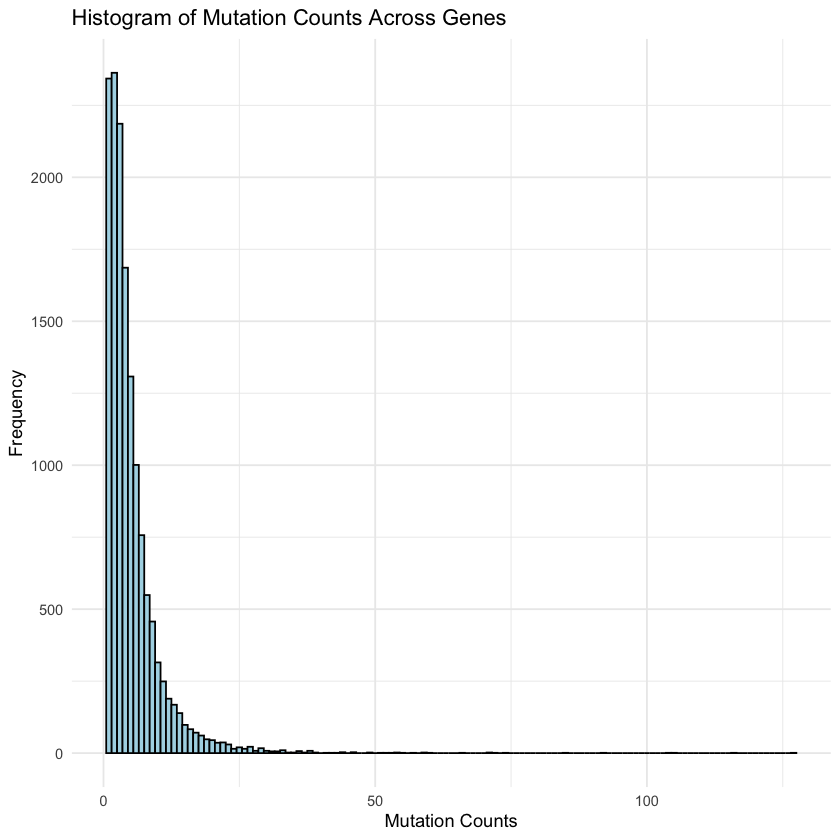

Dispersion (variance/mean): 5.869462 
Observed zeros: 0 
Expected zeros under Poisson: 81.20767 


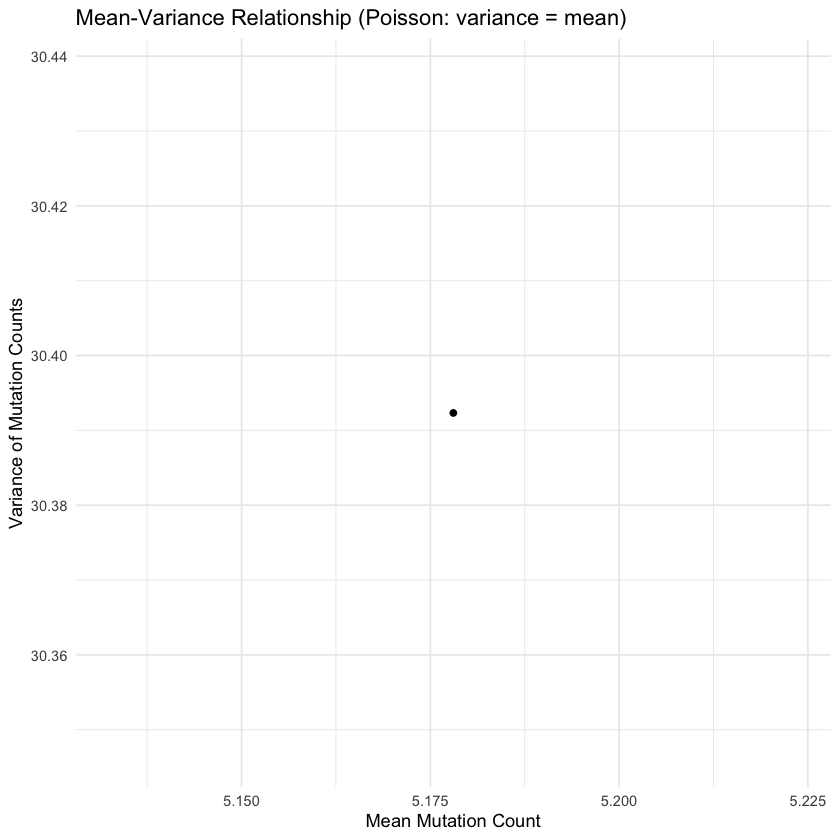

In [136]:
ggplot(mutation_counts_filtered, aes(x = observed_mutations)) +
  geom_histogram(binwidth = 1, fill = "lightblue", color = "black") +
  labs(x = "Mutation Counts", y = "Frequency", 
       title = "Histogram of Mutation Counts Across Genes") +
  theme_minimal()

mean_counts <- mean(mutation_counts_filtered$observed_mutations)
var_counts <- var(mutation_counts_filtered$observed_mutations)
plot_data <- data.frame(mean = mean_counts, variance = var_counts)

ggplot(plot_data, aes(x = mean, y = variance)) +
  geom_point() +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "red") +
  labs(x = "Mean Mutation Count", y = "Variance of Mutation Counts",
       title = "Mean-Variance Relationship (Poisson: variance = mean)") +
  theme_minimal()

dispersion <- var(mutation_counts_filtered$observed_mutations) / mean(mutation_counts_filtered$observed_mutations)
cat("Dispersion (variance/mean):", dispersion, "\n")

observed_zeros <- sum(mutation_counts_filtered$observed_mutations == 0)
expected_zeros_poisson <- sum(dpois(0, lambda = mean(mutation_counts_filtered$observed_mutations)) * nrow(mutation_counts_filtered))
cat("Observed zeros:", observed_zeros, "\n")
cat("Expected zeros under Poisson:", expected_zeros_poisson, "\n")

`geom_smooth()` using formula = 'y ~ x'



	Pearson's product-moment correlation

data:  mutation_counts_filtered$gene_length and mutation_counts_filtered$observed_mutations
t = 69.869, df = 14158, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4940053 0.5185029
sample estimates:
      cor 
0.5063562 



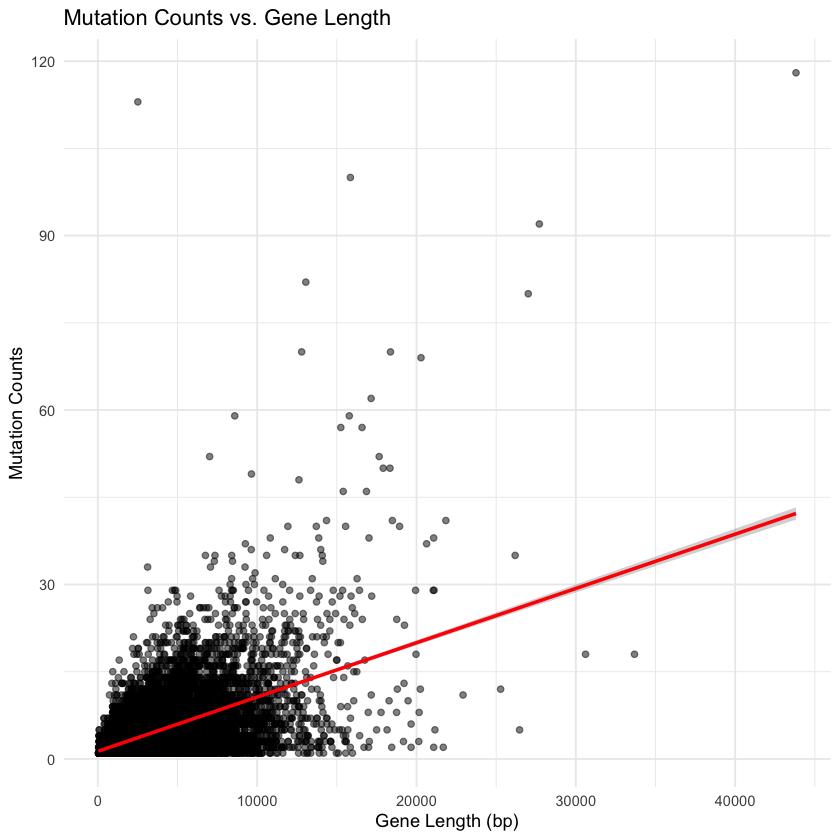

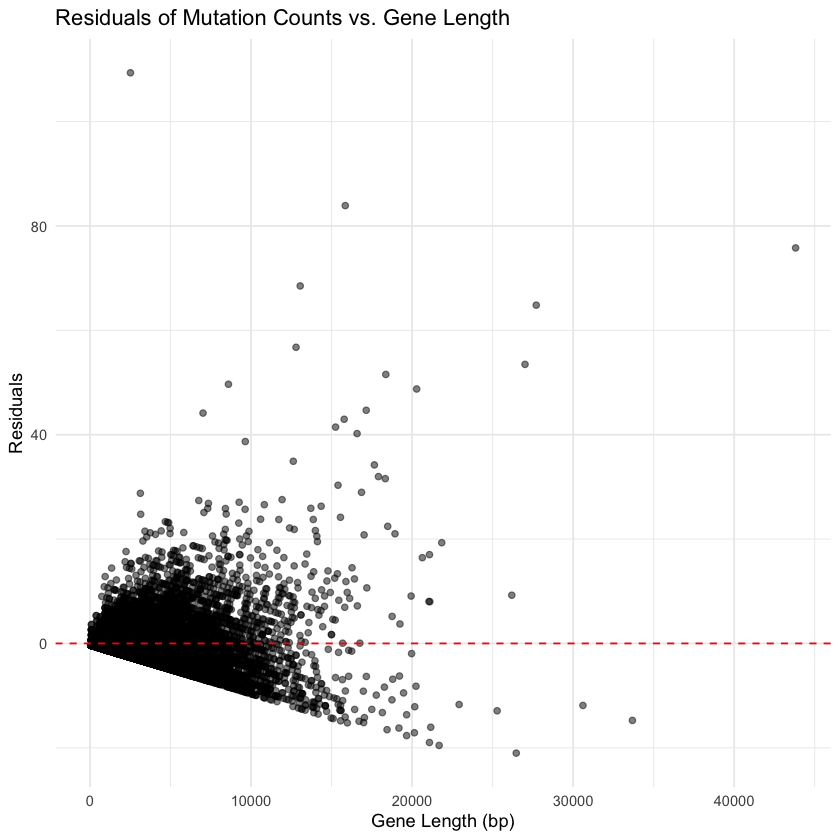

In [183]:
# Scatter Plot
ggplot(mutation_counts_filtered, aes(x = gene_length, y = observed_mutations)) +
  geom_point(alpha = 0.5) +
  geom_smooth(method = "lm", color = "red") +
  labs(x = "Gene Length (bp)", y = "Mutation Counts", 
       title = "Mutation Counts vs. Gene Length") +
  theme_minimal()

# Correlation Test
cor_test <- cor.test(mutation_counts_filtered$gene_length, mutation_counts_filtered$observed_mutations, method = "pearson")
print(cor_test)

# Linear Model and Residual Plot
lm_fit <- lm(observed_mutations ~ gene_length, data = mutation_counts_filtered)
mutation_counts_filtered$residuals <- residuals(lm_fit)

ggplot(mutation_counts_filtered, aes(x = gene_length, y = residuals)) +
  geom_point(alpha = 0.5) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(x = "Gene Length (bp)", y = "Residuals", 
       title = "Residuals of Mutation Counts vs. Gene Length") +
  theme_minimal()

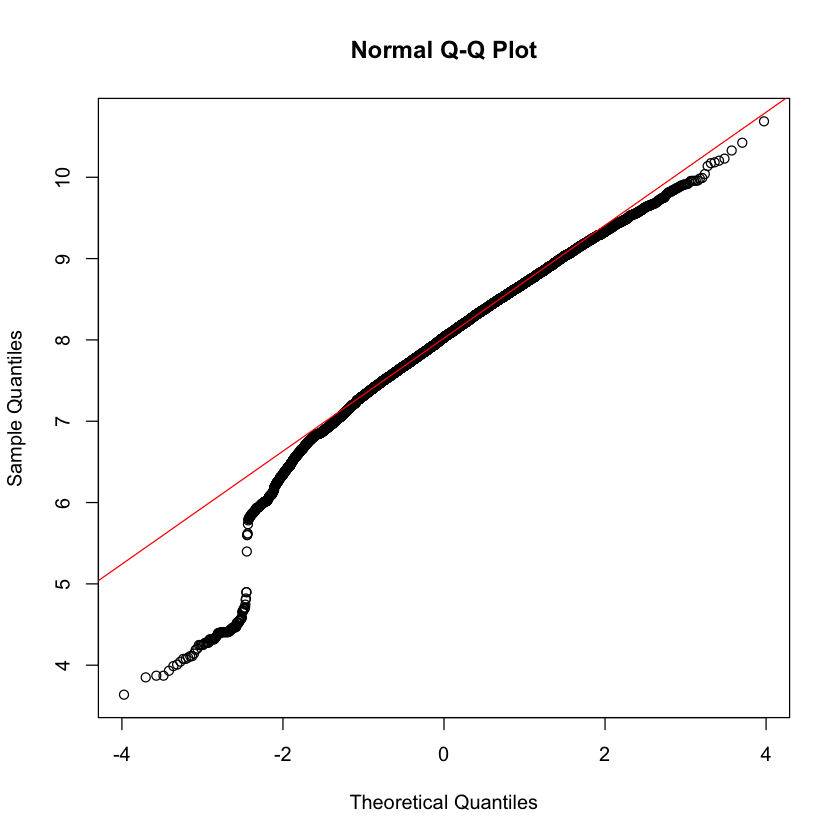

ERROR: Error in shapiro.test(log(mutation_counts_filtered$gene_length)): sample size must be between 3 and 5000


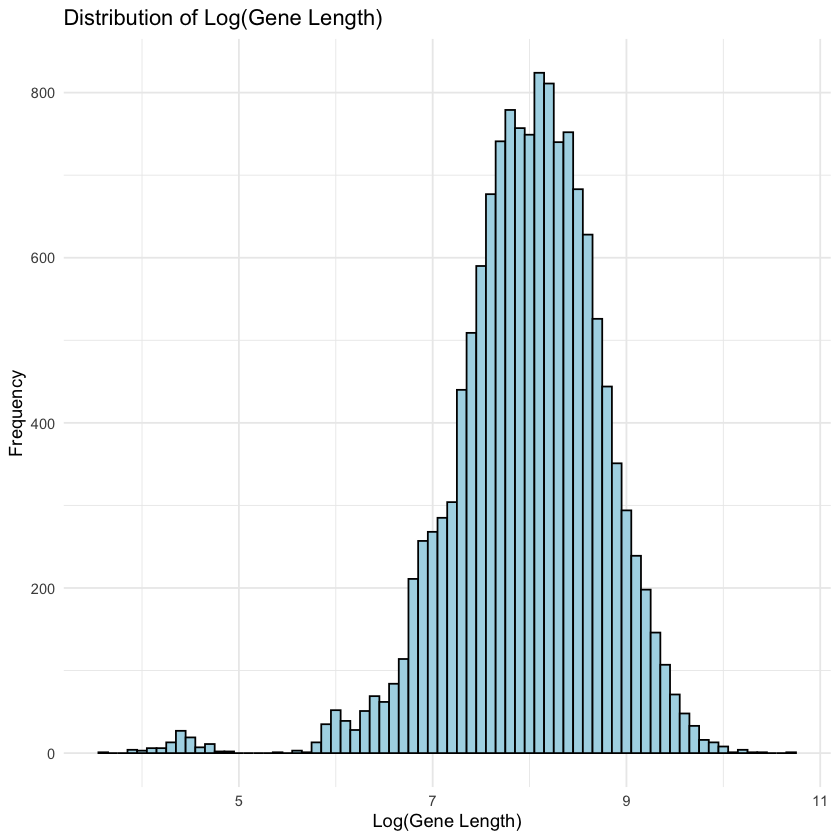

In [185]:
# QQ Plot for log(gene_length)
qqnorm(log(mutation_counts_filtered$gene_length))
qqline(log(mutation_counts_filtered$gene_length), col = "red")

# Histogram of log(gene_length)
ggplot(mutation_counts_filtered, aes(x = log(gene_length))) +
  geom_histogram(binwidth = 0.1, fill = "lightblue", color = "black") +
  labs(x = "Log(Gene Length)", y = "Frequency", 
       title = "Distribution of Log(Gene Length)") +
  theme_minimal()

# Shapiro-Wilk Test
shapiro_test <- shapiro.test(log(mutation_counts_filtered$gene_length))
print(shapiro_test)

## Apply poisson distribution to calculate expected mutations and run poisson test

In [152]:
total_mutations <- nrow(STAD_mutation_filtered_pass)
total_gene_length <- sum(mutation_counts_filtered$gene_length, na.rm = TRUE)
mutation_counts_filtered$expected_mutations <- (mutation_counts_filtered$gene_length / total_gene_length) * total_mutations

mutation_counts_filtered$p_value <- mapply(function(obs, exp) {
  poisson.test(obs, r = exp, alternative = "two.sided")$p.value
}, mutation_counts_filtered$observed_mutations, mutation_counts_filtered$expected_mutations)

mutation_counts_filtered$adj_p_value <- p.adjust(mutation_counts_filtered$p_value, method = "BH")
mutation_counts_filtered$selection <- ifelse(mutation_counts_filtered$adj_p_value < 0.05 & mutation_counts_filtered$observed_mutations > mutation_counts_filtered$expected_mutations, "Positive",
                                    ifelse(mutation_counts_filtered$adj_p_value < 0.05 & mutation_counts_filtered$observed_mutations < mutation_counts_filtered$expected_mutations, "Negative", "Neutral"))

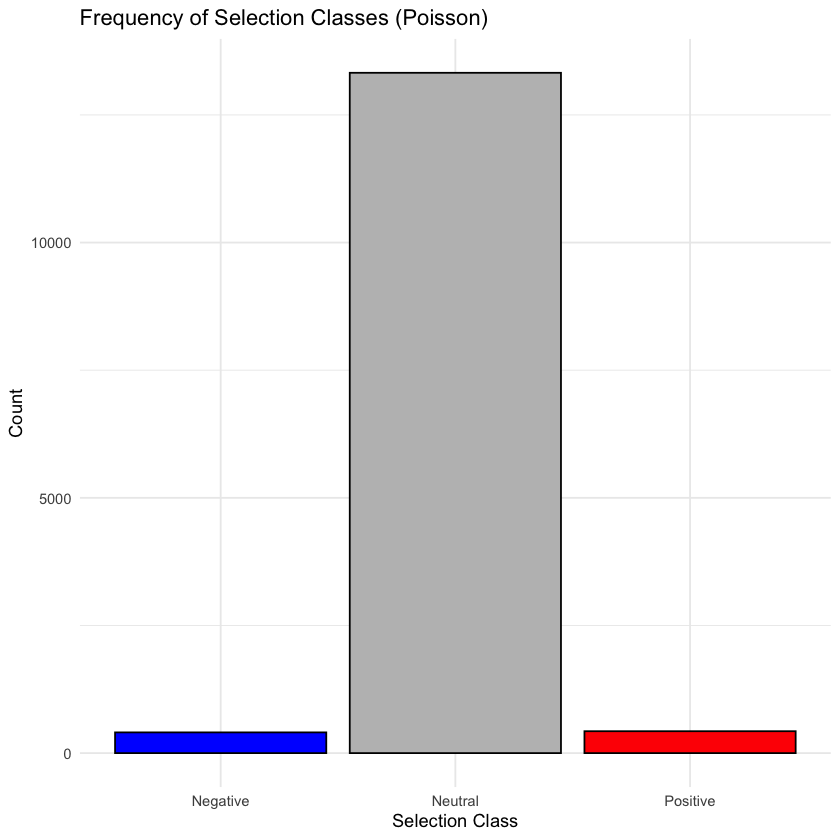

In [187]:
class_counts_df <- as.data.frame(table(mutation_counts_filtered$selection))
colnames(class_counts_df) <- c("Selection_Class", "Count")

ggplot(class_counts_df, aes(x = Selection_Class, y = Count, fill = Selection_Class)) +
  geom_bar(stat = "identity", color = "black") +
  scale_fill_manual(values = c("Positive" = "red", "Negative" = "blue", "Neutral" = "grey")) +
  labs(x = "Selection Class", y = "Count", 
       title = "Frequency of Selection Classes (Poisson)") +
  theme_minimal() +
  theme(legend.position = "none")

# Some hypotheses

In [168]:
null_model <- glm(observed_mutations ~ 1 + (log_gene_length), 
                  family = poisson(), 
                  data = mutation_counts_filtered)

alt1_model <- glm(observed_mutations ~ avg_sift + (log_gene_length), 
                  family = poisson(), 
                  data = mutation_counts_filtered)

alt2_model <- glm(observed_mutations ~ dN_dS + (log_gene_length), 
                  family = poisson(), 
                  data = mutation_counts_filtered)

combined_model <- glm(observed_mutations ~ avg_sift + dN_dS + (log_gene_length), 
                      family = poisson(), 
                      data = mutation_counts_filtered)

models <- list("SIFT" = alt1_model, 
               "Mutation Type" = alt2_model, 
               "Combined" = combined_model)

for (name in names(models)) {
  alt_model <- models[[name]]
  lrt <- lrtest(null_model, alt_model)
  cat(sprintf("\nLikelihood Ratio Test: %s vs. Null\n", name))
  cat(sprintf("LR Statistic: %.2f, P-value: %.4f\n", lrt[2, "Chisq"], lrt[2, "Pr(>Chisq)"]))
}

dispersion_stat <- summary(combined_model)$deviance / summary(combined_model)$df.residual
cat("\nDispersion statistic for Combined Poisson Model:", dispersion_stat, "\n")
if (dispersion_stat > 1.5) {
  cat("Overdispersion.\n")
}


Likelihood Ratio Test: SIFT vs. Null
LR Statistic: 48.46, P-value: 0.0000

Likelihood Ratio Test: Mutation Type vs. Null
LR Statistic: 231.65, P-value: 0.0000

Likelihood Ratio Test: Combined vs. Null
LR Statistic: 290.04, P-value: 0.0000

Dispersion statistic for Combined Poisson Model: 2.58609 
Overdispersion.


## Apply negative binomial 

In [154]:
nb_model <- glm.nb(observed_mutations ~ offset(log(gene_length)), data = mutation_counts_filtered)
mutation_counts_filtered$nb_expected <- predict(nb_model, type = "response")
mutation_counts_filtered$nb_p_value <- pchisq(2 * (logLik(glm.nb(observed_mutations ~ 1, data = mutation_counts_filtered)) - 
                                                  logLik(glm.nb(observed_mutations ~ offset(log(gene_length)), data = mutation_counts_filtered))), 
                                              df = 1, lower.tail = FALSE)

mutation_counts_filtered$nb_adj_p_value <- p.adjust(mutation_counts_filtered$nb_p_value, method = "BH")
mutation_counts_filtered$nb_selection <- ifelse(mutation_counts_filtered$nb_adj_p_value < 0.05 & 
                                                mutation_counts_filtered$observed_mutations > mutation_counts_filtered$nb_expected, "Positive",
                                                ifelse(mutation_counts_filtered$nb_adj_p_value < 0.05 & 
                                                       mutation_counts_filtered$observed_mutations < mutation_counts_filtered$nb_expected, "Negative", "Neutral"))

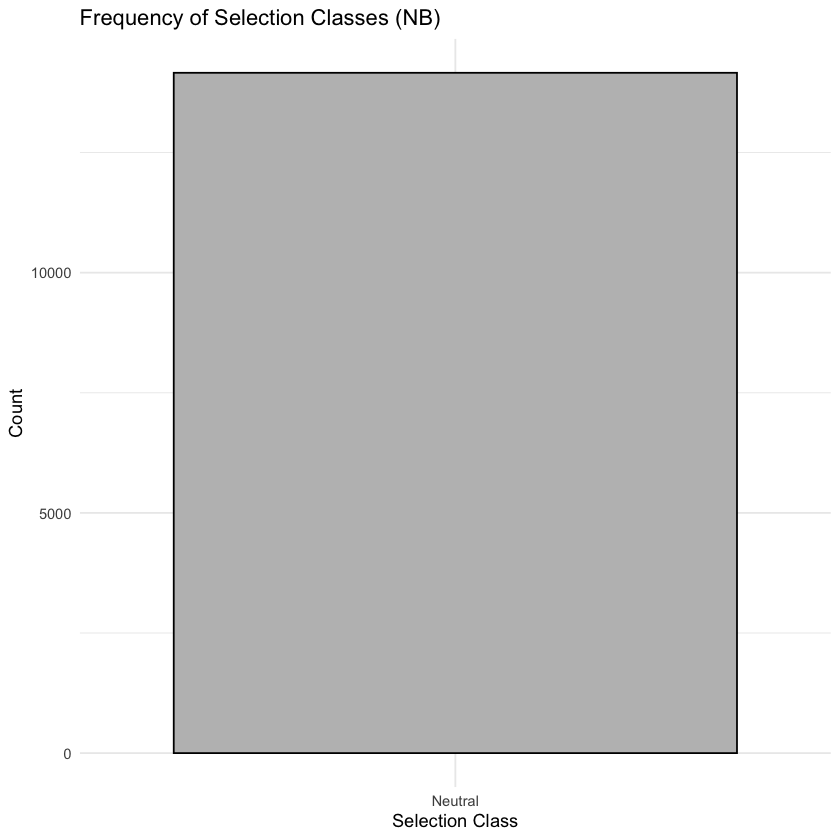

In [186]:
class_counts_df <- as.data.frame(table(mutation_counts_filtered$nb_selection))
colnames(class_counts_df) <- c("Selection_Class", "Count")

ggplot(class_counts_df, aes(x = Selection_Class, y = Count, fill = Selection_Class)) +
  geom_bar(stat = "identity", color = "black") +
  scale_fill_manual(values = c("Positive" = "red", "Negative" = "blue", "Neutral" = "grey")) +
  labs(x = "Selection Class", y = "Count", 
       title = "Frequency of Selection Classes (NB)") +
  theme_minimal() +
  theme(legend.position = "none")

# Try different hypothesis on NB

In [118]:
mutation_counts_with_GeneLength <- mutation_counts %>%
  left_join(gene_lengths, by = c("Hugo_Symbol" = "hgnc_symbol"))

mutation_counts_filtered <- mutation_counts_with_GeneLength %>%
  filter(!is.na(gene_length))

In [120]:
STAD_mutation_filtered_pass <- STAD_mutation_filtered_pass %>%
mutate(
  SIFT_numeric = as.numeric(str_extract(SIFT, "(?<=\\()\\d*\\.?\\d*(?=\\))")),
  SIFT = ifelse(SIFT == ".", NA, SIFT)
)

impact_scores <- STAD_mutation_filtered_pass %>%
  group_by(Hugo_Symbol) %>%
  summarise(avg_sift = mean(SIFT_numeric, na.rm = TRUE)) %>%
  ungroup()

mutation_counts_filtered <- mutation_counts_filtered %>%
  left_join(impact_scores, by = "Hugo_Symbol")

mutation_types <- STAD_mutation_filtered_pass %>%
  group_by(Hugo_Symbol) %>%
  summarise(
    dN = sum(Variant_Classification %in% c("Missense_Mutation", "Nonsense_Mutation", "Frame_Shift_Del", "Frame_Shift_Ins", "Splice_Site")),
    dS = sum(Variant_Classification == "Silent")
  ) %>%
  ungroup() %>%
  mutate(dN_dS = dN / (dS + 1e-6))

mutation_counts_filtered <- mutation_counts_filtered %>%
  left_join(mutation_types[, c("Hugo_Symbol", "dN_dS")], by = "Hugo_Symbol")

In [121]:
mutation_counts_filtered$avg_sift <- replace(mutation_counts_filtered$avg_sift, is.na(mutation_counts_filtered$avg_sift), 0)


In [182]:
mutation_counts_filtered$log_gene_length <- log(mutation_counts_filtered$gene_length + 1e-6)

# Null Model
null_model <- glm.nb(observed_mutations ~ 1 + (log_gene_length), 
                     data = mutation_counts_filtered)

# Alternative Models
alt1_model <- glm.nb(observed_mutations ~ avg_sift + (log_gene_length), 
                     data = mutation_counts_filtered)

alt2_model <- glm.nb(observed_mutations ~ dN_dS + (log_gene_length), 
                     data = mutation_counts_filtered)


combined_model <- glm.nb(observed_mutations ~ avg_sift + dN_dS + (log_gene_length), 
                         data = mutation_counts_filtered)

# Likelihood Ratio Tests
models <- list("SIFT" = alt1_model, 
               "Mutation Type" = alt2_model,  
               "Combined" = combined_model)

for (name in names(models)) {
  alt_model <- models[[name]]
  lrt <- lrtest(null_model, alt_model)
  cat(sprintf("\nLikelihood Ratio Test: %s vs. Null\n", name))
  cat(sprintf("LR Statistic: %.30f, P-value: %.30f\n", lrt[2, "Chisq"], lrt[2, "Pr(>Chisq)"]))
}


Likelihood Ratio Test: SIFT vs. Null
LR Statistic: 44.810087786769145168364048004150, P-value: 0.000000000021710131865030277610

Likelihood Ratio Test: Mutation Type vs. Null
LR Statistic: 36.792007631593151018023490905762, P-value: 0.000000001314279436826499785766

Likelihood Ratio Test: Combined vs. Null
LR Statistic: 84.759404841432115063071250915527, P-value: 0.000000000000000000393304661703



Genes under Positive Selection:
# A tibble: 16 × 6
   Hugo_Symbol observed_mutations expected_mutations_combined diff_obs_exp
   <chr>                    <int>                       <dbl>        <dbl>
 1 TP53                       116                        4.21        112. 
 2 LRP1B                      105                       12.9          92.1
 3 ARID1A                      66                        8.89         57.1
 4 CSMD3                       85                       11.9          73.1
 5 PCDH15                      54                        8.11         45.9
 6 FLG                         71                       11.3          59.7
 7 SYNE1                      104                       18.3          85.7
 8 TNXB                        33                        4.98         28.0
 9 TPO                         32                        4.95         27.1
10 MUC16                      127                       24.2         103. 
11 FAT4                        72               

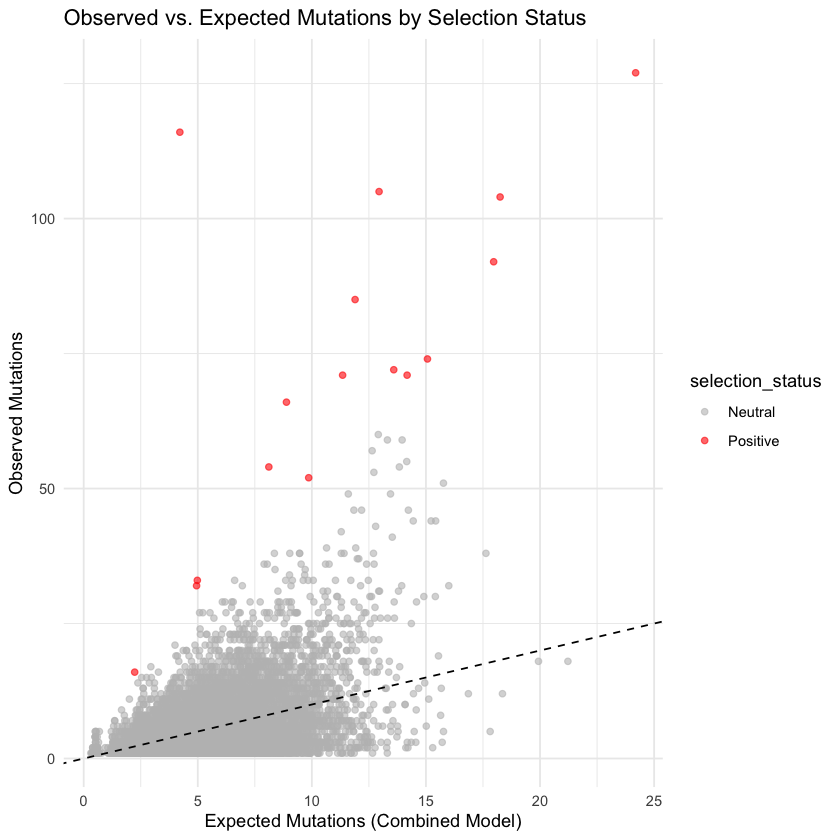

In [171]:
mutation_counts_filtered$expected_mutations_combined <- predict(combined_model, type = "response")

mutation_counts_filtered <- mutation_counts_filtered %>%
  mutate(
    diff_obs_exp = observed_mutations - expected_mutations_combined,
    ratio_obs_exp = observed_mutations / expected_mutations_combined
  )

# Use a Negative Binomial test: compare observed to expected under the NB distribution
mutation_counts_filtered$p_value <- sapply(1:nrow(mutation_counts_filtered), function(i) {
  obs <- mutation_counts_filtered$observed_mutations[i]
  exp <- mutation_counts_filtered$expected_mutations_combined[i]
  theta <- combined_model$theta
  
  # Two-sided test: P(observed >= obs) if obs > exp, P(observed <= obs) if obs < exp
  if (obs > exp) {
    p <- 1 - pnbinom(obs - 1, mu = exp, size = theta)
  } else {
    p <- pnbinom(obs, mu = exp, size = theta)
  }
  return(p)
})

mutation_counts_filtered$adj_p_value <- p.adjust(mutation_counts_filtered$p_value, method = "BH")
mutation_counts_filtered <- mutation_counts_filtered %>%
  mutate(
    selection_status = case_when(
      adj_p_value < 0.05 & ratio_obs_exp > 1 ~ "Positive",
      adj_p_value < 0.05 & ratio_obs_exp < 1 ~ "Negative",
      TRUE ~ "Neutral"
    )
  )

positive_selection <- mutation_counts_filtered %>%
  filter(selection_status == "Positive") %>%
  arrange(adj_p_value) %>%
  dplyr::select(Hugo_Symbol, observed_mutations, expected_mutations_combined, diff_obs_exp, ratio_obs_exp, adj_p_value)

negative_selection <- mutation_counts_filtered %>%
  filter(selection_status == "Negative") %>%
  arrange(adj_p_value) %>%
  dplyr::select(Hugo_Symbol, observed_mutations, expected_mutations_combined, diff_obs_exp, ratio_obs_exp, adj_p_value)

cat("\nGenes under Positive Selection:\n")
print(positive_selection)
cat("\nGenes under Negative Selection:\n")
print(negative_selection)

library(ggplot2)
ggplot(mutation_counts_filtered, aes(x = expected_mutations_combined, y = observed_mutations, color = selection_status)) +
  geom_point(alpha = 0.6) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "black") +
  scale_color_manual(values = c("Positive" = "red", "Negative" = "blue", "Neutral" = "gray")) +
  labs(x = "Expected Mutations (Combined Model)", y = "Observed Mutations",
       title = "Observed vs. Expected Mutations by Selection Status") +
  theme_minimal()

## Apply binomial on dN/dS

In [125]:
mutation_types <- STAD_mutation_filtered_pass %>%
  group_by(Hugo_Symbol) %>%
  summarise(dN = sum(Variant_Classification %in% c("Missense_Mutation", "Nonsense_Mutation", "Frame_Shift_Del", "Frame_Shift_Ins", "Splice_Site")),
            dS = sum(Variant_Classification == "Silent")) %>%
  ungroup()

mutation_counts_filtered <- mutation_counts_filtered %>%
  left_join(mutation_types, by = "Hugo_Symbol")

expected_dN_dS <- 1
mutation_counts_filtered$total_mutations <- mutation_counts_filtered$dN + mutation_counts_filtered$dS
mutation_counts_filtered$expected_dN <- mutation_counts_filtered$total_mutations * (expected_dN_dS / (1 + expected_dN_dS))

mutation_counts_filtered$dnds_p_value <- mapply(function(dN, total, exp_dN) {
  if (total == 0) return(1)
  binom.test(dN, total, p = exp_dN/total, alternative = "two.sided")$p.value
}, mutation_counts_filtered$dN, mutation_counts_filtered$total_mutations, mutation_counts_filtered$expected_dN)

mutation_counts_filtered$dnds_adj_p_value <- p.adjust(mutation_counts_filtered$dnds_p_value, method = "BH")
mutation_counts_filtered$dnds_selection <- ifelse(mutation_counts_filtered$dnds_adj_p_value < 0.05 & 
                                                  mutation_counts_filtered$dN > mutation_counts_filtered$expected_dN, "Positive",
                                                  ifelse(mutation_counts_filtered$dnds_adj_p_value < 0.05 & 
                                                         mutation_counts_filtered$dN < mutation_counts_filtered$expected_dN, "Negative", "Neutral"))

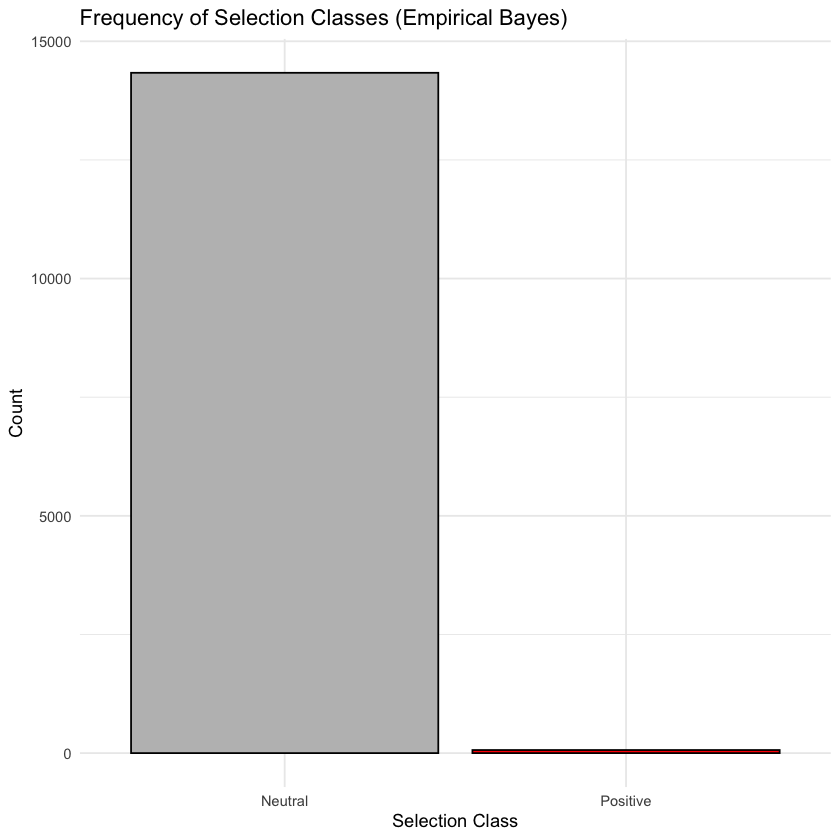

In [126]:
class_counts_df <- as.data.frame(table(mutation_counts_filtered$dnds_selection))
colnames(class_counts_df) <- c("Selection_Class", "Count")

ggplot(class_counts_df, aes(x = Selection_Class, y = Count, fill = Selection_Class)) +
  geom_bar(stat = "identity", color = "black") +
  scale_fill_manual(values = c("Positive" = "red", "Negative" = "blue", "Neutral" = "grey")) +
  labs(x = "Selection Class", y = "Count", 
       title = "Frequency of Selection Classes (Empirical Bayes)") +
  theme_minimal() +
  theme(legend.position = "none")

# Plotting

In [132]:
# mutation_counts_filtered$logFC <- log2(mutation_counts_filtered$observed_mutations / mutation_counts_filtered$expected_mutations)
# mutation_counts_filtered$neg_log_p <- -log10(mutation_counts_filtered$adj_p_value)

# ggplot(mutation_counts_filtered, aes(x = logFC, y = neg_log_p, color = selection)) +
#   geom_point(alpha = 0.6) +
#   scale_color_manual(values = c("Positive" = "red", "Negative" = "blue", "Neutral" = "grey")) +
#   labs(x = "Log2 Fold Change (Observed/Expected)", y = "-log10(Adjusted P-value)",
#        title = "Volcano Plot of Mutation Selection") +
#   theme_minimal() +
#   geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "black") +
#   geom_vline(xintercept = 0, linetype = "dashed", color = "black")

In [133]:
# library(pheatmap)

# selection_matrix <- as.matrix(mutation_counts_filtered[, c("selection", "nb_selection", "dnds_selection")])
# selection_matrix[selection_matrix == "Positive"] <- 1
# selection_matrix[selection_matrix == "Negative"] <- -1
# selection_matrix[selection_matrix == "Neutral"] <- 0
# selection_matrix <- apply(selection_matrix, 2, as.numeric)

# pheatmap(selection_matrix, 
#          cluster_rows = TRUE, cluster_cols = FALSE,
#          color = c("blue", "grey", "red"),
#          breaks = c(-1.5, -0.5, 0.5, 1.5),
#          labels_row = mutation_counts_filtered$Hugo_Symbol,
#          main = "Selection Across Methods")

In [134]:
# significant_genes <- mutation_counts_filtered %>%
#   filter(adj_p_value < 0.05) %>%
#   slice_head(n = 20)

# plot_data <- data.frame(
#   Gene = rep(significant_genes$Hugo_Symbol, 2),
#   Counts = c(significant_genes$observed_mutations, significant_genes$expected_mutations),
#   Type = rep(c("Observed", "Expected"), each = nrow(significant_genes))
# )

# ggplot(plot_data, aes(x = Gene, y = Counts, fill = Type)) +
#   geom_bar(stat = "identity", position = "dodge") +
#   scale_fill_manual(values = c("Observed" = "dodgerblue", "Expected" = "orange")) +
#   labs(x = "Gene", y = "Mutation Counts", title = "Observed vs. Expected Mutations in Significant Genes") +
#   theme_minimal() +
#   theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [135]:
# mutation_counts_filtered$index <- 1:nrow(mutation_counts_filtered)
# ggplot(mutation_counts_filtered, aes(x = index, y = neg_log_p, color = selection)) +
#   geom_point() +
#   scale_color_manual(values = c("Positive" = "red", "Negative" = "blue", "Neutral" = "grey")) +
#   labs(x = "Gene Index", y = "-log10(Adjusted P-value)", title = "Manhattan Plot of Mutation Selection") +
#   theme_minimal() +
#   geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "black")

# Empirical Bayes

In [171]:
library(MASS)

nb_fit <- glm.nb(observed_mutations ~ offset(log(gene_length)), data = mutation_counts_filtered)
theta <- nb_fit$theta
mu <- fitted(nb_fit)

mutation_counts_filtered$eb_selection <- (mutation_counts_filtered$observed_mutations + theta) / (mu + theta)
mutation_counts_filtered$eb_selection_var <- (mutation_counts_filtered$observed_mutations + theta) / (mu + theta)^2
mutation_counts_filtered$eb_selection_lower <- mutation_counts_filtered$eb_selection - 1.96 * sqrt(mutation_counts_filtered$eb_selection_var)
mutation_counts_filtered$eb_selection_upper <- mutation_counts_filtered$eb_selection + 1.96 * sqrt(mutation_counts_filtered$eb_selection_var)
mutation_counts_filtered$eb_selection_class <- ifelse(mutation_counts_filtered$eb_selection_lower > 1, "Positive",
                                                      ifelse(mutation_counts_filtered$eb_selection_upper < 1, "Negative", "Neutral"))

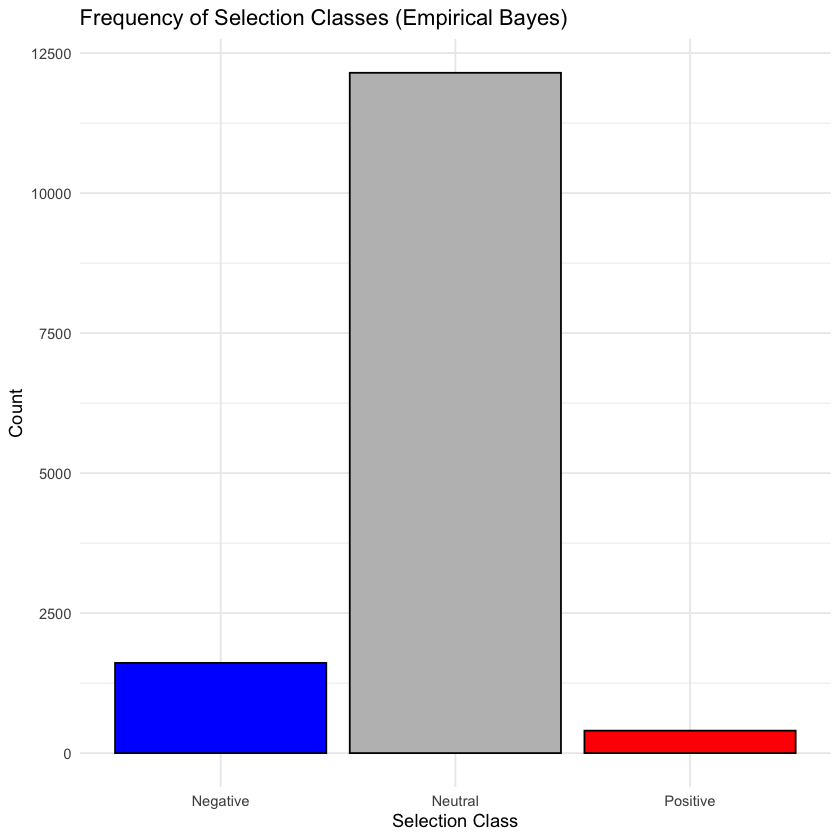

In [173]:
class_counts_df <- as.data.frame(table(mutation_counts_filtered$eb_selection_class))
colnames(class_counts_df) <- c("Selection_Class", "Count")

ggplot(class_counts_df, aes(x = Selection_Class, y = Count, fill = Selection_Class)) +
  geom_bar(stat = "identity", color = "black") +
  scale_fill_manual(values = c("Positive" = "red", "Negative" = "blue", "Neutral" = "grey")) +
  labs(x = "Selection Class", y = "Count", 
       title = "Frequency of Selection Classes (Empirical Bayes)") +
  theme_minimal() +
  theme(legend.position = "none")

# Benchmark against filtered STAD_mutation

### Check if SNP contamination

In [ ]:
print(STAD_dndsout$nbreg$theta)

In [55]:
STAD_mutation_sub <- STAD_mutation_filtered_pass[, c("patient_id", "Chromosome", "Start_Position", "Reference_Allele", "Tumor_Seq_Allele2")]
colnames(STAD_mutation_sub) <- c("sampleID", "chr", "pos", "ref", "mut")

In [56]:
STAD_dndsout <- dndscv(STAD_mutation_sub)

[1] Loading the environment...

[2] Annotating the mutations...

Warning message in dndscv(STAD_mutation_sub):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”
Warning message in dndscv(STAD_mutation_sub):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”
    Note: 119 mutations removed for exceeding the limit of mutations per gene per sample (see the max_muts_per_gene_per_sample argument in dndscv)

    15% ...

    30% ...

    45% ...

    59% ...

    74% ...

    89% ...

Warning message in dndscv(STAD_mutation_sub):
“62 (0.092%) mutations have a wrong reference base (see the affected mutations in dndsout$wrongmuts). Please identify the causes and rerun dNdScv.”
[3] Estimating global rates...

[4] Running dNdSloc...

[5] Running dNdScv...

    Regression model for substitutions (theta = 5.26).

    Regression mo

In [57]:
STAD_sel_cv = STAD_dndsout$sel_cv
STAD_signif_genes = STAD_sel_cv[STAD_sel_cv$qglobal_cv<0.1, c("gene_name","qglobal_cv")]

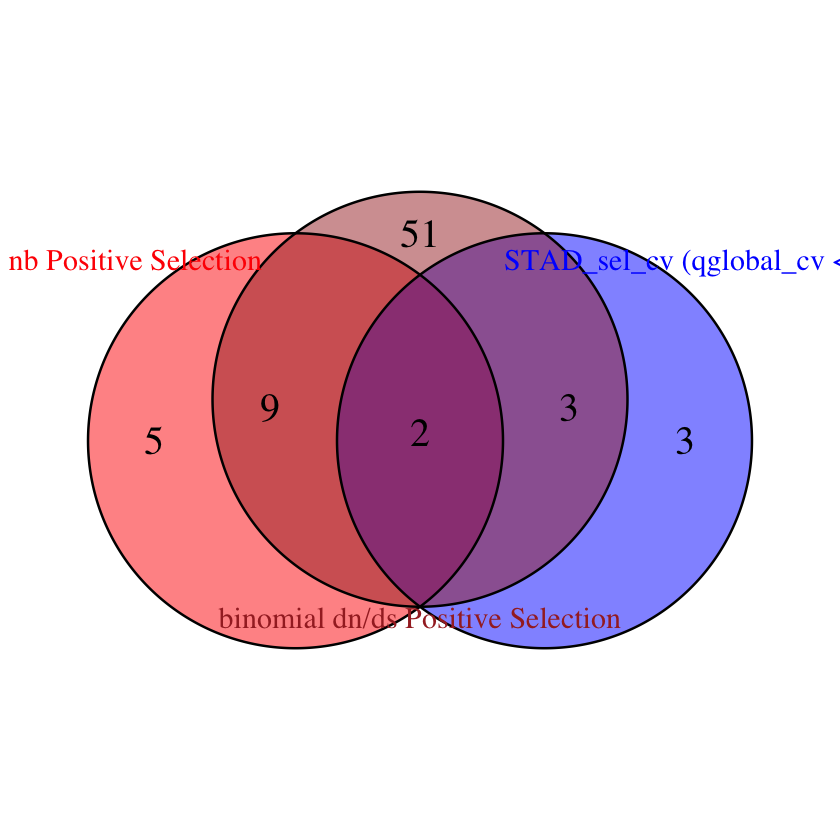

In [178]:
nb_sig_genes <- mutation_counts_filtered %>%
  filter(selection_status == "Positive" & adj_p_value < 0.06) %>%
  pull(Hugo_Symbol) %>%
  unique()

bi_dnds_positive_genes <- mutation_counts_filtered %>%
  filter(dnds_selection == "Positive" & dnds_adj_p_value < 0.05) %>%
  pull(Hugo_Symbol) %>%
  unique()

dndscv_significant_genes <- STAD_sel_cv %>%
  filter(qglobal_cv < 0.05) %>%
  pull(gene_name) %>%
  unique()

fill_colors <- c("red", "blue", 'brown')

venn_plot <- venn.diagram(
  x = list(
    "nb Positive Selection" = nb_sig_genes,
    "STAD_sel_cv (qglobal_cv < 0.1)" = dndscv_significant_genes,
    "binomial dn/ds Positive Selection" = bi_dnds_positive_genes
  ),
  filename = NULL, 
  fill = fill_colors,
  alpha = 0.5,
  label.col = "black",
  cex = 2, 
  cat.cex = 1.5,
  cat.col = fill_colors,
  margin = 0.1
)
grid.draw(venn_plot)

In [173]:
intersect(nb_sig_genes, dndscv_significant_genes)

[1] "ARID1A" "TP53"

In [174]:
intersect(bi_dnds_positive_genes, dndscv_significant_genes)

[1] "ARID1A" "HLA-B"  "KRAS"   "PIK3CA" "TP53"

In [175]:
signif_genes_localmodel = as.vector(STAD_dndsout$sel_loc$gene_name[STAD_dndsout$sel_loc$qall_loc<0.1])
print(signif_genes_localmodel)

[1] "ARID1A" "TP53"   "PIK3CA"


# Take a look at full STAD_mutation

In [162]:
full_STAD_mutation <- STAD_mutation[, c("patient_id", "Chromosome", "Start_Position", "Reference_Allele", "Tumor_Seq_Allele2")]
colnames(full_STAD_mutation) <- c("sampleID", "chr", "pos", "ref", "mut")

In [163]:
full_STAD_dndsout <- dndscv(full_STAD_mutation)

[1] Loading the environment...

[2] Annotating the mutations...

Warning message in dndscv(full_STAD_mutation):
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”
Warning message in dndscv(full_STAD_mutation):
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”
    Note: 3 samples excluded for exceeding the limit of mutations per sample (see the max_coding_muts_per_sample argument in dndscv). 406 samples left after filtering.

    Note: 285 mutations removed for exceeding the limit of mutations per gene per sample (see the max_muts_per_gene_per_sample argument in dndscv)

    13% ...

    26% ...

    39% ...

    51% ...

    64% ...

    77% ...

    90% ...

Warning message in dndscv(full_STAD_mutation):
“73 (0.094%) mutations have a wrong reference base (see the affected mutations in dndsout$wrongmuts). Please identi

In [164]:
print(full_STAD_dndsout$nbreg$theta)

[1] 5.733646


In [165]:
full_signif_genes_localmodel = as.vector(full_STAD_dndsout$sel_loc$gene_name[full_STAD_dndsout$sel_loc$qall_loc<0.1])
print(full_signif_genes_localmodel)

[1] "ARID1A" "TP53"   "PIK3CA"
